<a href="https://colab.research.google.com/github/alonkipnis/Covid19/blob/master/proto_Covid19_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

categories
(with dwell times):
 
+ state:
  - ​healthy 
  - newly infected 
  - infected 
  - hospitalized 
  - immune 
  - dead

- behavior
  - safe
  - unsafe
- viral type
  - ​WT
  ​- MT
- symptomatic
  - asymptomatic
  - symptomatic
  - severely symptomatic
- quarantined
  - yes
  - no
- on-meds
  - yes
  - no
- at-risk
  - ​yes
  - no
 
complex mass function:
- split by: 
  - viral type
  - dependencies:
  - ​​quarantine
  - ​​hospitalization
  - ​on-meds
  - ​​no for the above
  - ​​quarantine * on-med
- transitions acting on population mass functions:
 - ​all parameters can have an iterative index setting---
 - ​one pass through 1-3 constitutes an iterative cycle---
 - ​dependencies and modulator determine the proportioned fate
   ​​in a multiplicative fashion, normalized to 1.0
 
1) healthy ->
- ​split by: 
  - viral type
- ​fate:
  - ​​healthy
  - ​​newly infected
- ​​​viral type
- ​dependencies:
  - ​​behavior
  - ​​on-meds
- ​modulator:
  - ​​mass viral type
 
2) newly infected, WT:
​newly infected, MT
 
3) newly infected:
- ​split by: viral type
- ​fate:
  - ​​infected
  - ​​​symptomatic
  - ​​​quarantine
  - ​​​on-meds
- ​dependencies:
  - ​​at-risk
  - ​on-meds
  
4) infected:
- ​split by: viral type
- ​fate:
  - infected
  - immune
  - hospitalized
  - dead
- ​dependencies:
  - ​​at-risk
  - ​on-meds
  - ​​symptomatic
  - ​​dwell time very sick
- ​modulator
​​mass hospitalization

5) immune:
- ​fate:
  - ​​healthy
- ​dependencies:
  - ​​dwell time immune
  - ​​on-meds



# Code

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
mpl.rcParams.update({'figure.max_open_warning':25})

mpl.rcParams['figure.figsize'] = [10.0, 7.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 14

States and their description:

In [0]:
lo_states = ['S', #->
            'E', 'Ep', # exposed
            'I', 'Ip', # infectious
             'Q', 'Qp', # quarantained (symptomatic)
             'H', 'Hp', # hospitalized (symptomatic, risk of dying)
              'R', # immuned
              'D'
              ] # dead

state_description = {'S' : 'suceptible', 
                      'E' : 'newly infected (WT)', # can mutate
                     'Ep' : 'newly infected (MT)', # cannot mutate
                      'I' : 'infectious (WT)', # infectious WT
                      'Ip' : 'infectious (MT)', # infectious MT
                      'Q' : 'quarantined (WT)', # symptomatic/quarantized WT
                      'Qp' : 'quarantined (MT)', # symptomatic/quarantized MT
                      'H' : 'hospitalized (WT)', # or severely ill WT
                      'Hp' : 'hospitalized (MT)', # or severely ill MT
                      'R' : 'immuned', # recovered for good
                      'D' : 'dead' 
                      } 

# dictionary: state name to number and back
st2i = dict([(nm,i) for i, nm in enumerate(lo_states) ])
i2st = dict([(i, nm) for i, nm in enumerate(lo_states) ])

In [0]:
baseline_parameters = {}
SUCEPTABILITY_FACTOR_WT = 0.5 #@param {type:"slider", min:0, max:2, step:0.05}
baseline_parameters['suceptability factor WT'] = SUCEPTABILITY_FACTOR_WT
SUCEPTABILITY_FACTOR_MT = 0.5 #@param {type:"slider", min:0, max:2, step:0.05}
baseline_parameters['suceptability factor MT'] = SUCEPTABILITY_FACTOR_MT

SPREADABILITY_FACTOR_WT = 0.5 #@param {type:"slider", min:0, max:2, step:0.05}
baseline_parameters['spreadability factor WT'] = SPREADABILITY_FACTOR_WT
SPREADABILITY_FACTOR_MT = 0.5 #@param {type:"slider", min:0, max:2, step:0.05}
baseline_parameters['spreadability factor MT'] = SPREADABILITY_FACTOR_MT

HOSPITALIZTION_RATE_WT = 0.2 #@param {type:"slider", min:0, max:2, step:0.05}
baseline_parameters['hospitalization rate WT'] = HOSPITALIZTION_RATE_WT
HOSPITALIZTION_RATE_MT = 0.2 #@param {type:"slider", min:0, max:2, step:0.05}
baseline_parameters['hospitalization rate MT'] = HOSPITALIZTION_RATE_MT
HOSPITALIZED_MORTALITY_RATE_WT = 0.1 #@param {type:"slider", min:0, max:2, step:0.05}
baseline_parameters['hospitalized mortality rate WT'] = HOSPITALIZED_MORTALITY_RATE_WT
HOSPITALIZED_MORTALITY_RATE_MT = 0.1 #@param {type:"slider", min:0, max:2, step:0.05}
baseline_parameters['hospitalized mortality rate MT'] = HOSPITALIZED_MORTALITY_RATE_MT 

MUTATION_RATE = 0.002 #@param {type:"slider", min:0, max:0.005, step:0.0005}
baseline_parameters['mutation rate'] = MUTATION_RATE

baseline_parameters['symptom development rate WT'] = 1
baseline_parameters['symptom development rate MT'] = 1


Time in each stage:

In [0]:
times = {}
INCUBATION_PERIOD = 3 #@param {type:"slider", min:0, max:14, step:1}
times['incubation period WT'] = INCUBATION_PERIOD
times['incubation period MT'] = INCUBATION_PERIOD

TIME_TO_SYMPTOMS = 5 #@param {type:"slider", min:0, max:14, step:1}
times['time to symptoms WT'] = TIME_TO_SYMPTOMS
times['time to symptoms MT'] = TIME_TO_SYMPTOMS

TIME_TO_RECOVERY = 10 #@param {type:"slider", min:0, max:14, step:1}
times['time to recovery WT'] = TIME_TO_RECOVERY
times['time to recovery MT'] = TIME_TO_RECOVERY

TIME_AT_HOSPITAL = 14 #@param {type:"slider", min:0, max:14, step:1}
times['time at hospital WT'] = TIME_AT_HOSPITAL
times['time at hospital MT'] = TIME_AT_HOSPITAL


Effect of meds:

In [0]:
PREVENTATIVE_ATTENUATION_FACTOR_WT = 1 #@param {type:"slider", min:0, max:1, step:0.1}
PREVENTATIVE_ATTENUATION_FACTOR_MT = 1 #@param {type:"slider", min:0, max:1, step:0.1}

SPREADING_ATTENUATION_FACTOR_WT = 1 #@param {type:"slider", min:0, max:1, step:0.1}
SPREADING_ATTENUATION_FACTOR_MT = 1 #@param {type:"slider", min:0, max:1, step:0.1}

TREATMENT_ATTENUATION_FACTOR_WT = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
TREATMENT_ATTENUATION_FACTOR_MT = 1 #@param {type:"slider", min:0, max:1, step:0.1}

meds_mod = {
    'susceptability factor WT' : PREVENTATIVE_ATTENUATION_FACTOR_WT,
    'susceptability factor MT' : PREVENTATIVE_ATTENUATION_FACTOR_MT,
    'spreading factor WT' : SPREADING_ATTENUATION_FACTOR_WT,
    'spreading factor MT' : SPREADING_ATTENUATION_FACTOR_MT,
    'hospitalization rate WT' : 
    'treatment WT' : TREATMENT_ATTENUATION_FACTOR_WT,
    'treatment WT' : TREATMENT_ATTENUATION_FACTOR_MT,
}


#### Populations:

In [0]:
SAFE_SUCEPTABILITY_ATTENUATION_FACTOR = 0.6 #@param {type:"slider", min:0, max:2, step:0.1}
SAFE_SPREADABILITY_ATTENUATION_FACTOR = 0.6 #@param {type:"slider", min:0, max:2, step:0.1}

RISK_MULTIPLIER_MODORATE = 3 #@param {type:"slider", min:1, max:50, step:1}
RISK_MULTIPLIER_HIGH = 5 #@param {type:"slider", min:1, max:50, step:1}

population1 = { 
    'description' : 'no risk, no symptoms, safe behavior',
               'fraction' : 0.4, 
                'symptom development rate' : 0,
                'suceptability' : SAFE_INFECTION_ATTENUATION_FACTOR,
               'spreadabilty' : SAFE_SPREAD_ATTENUATION_FACTOR,
                'risk factor to hospitalized' : 1,
                'risk factor to die' : 1,
  }

population2 = { 
    'description' : 'no risk, no symptoms, unsafe behavior',
               'fraction' : 0.1, 
                'symptom development rate' : 0,
                'suceptability' : 1,
               'spreadabilty' : 1,
                'risk factor to hospitalized' : 1,
                'risk factor to die' : 1,
  }

population3 = { 
    'description' : 'no risk, symptoms, safe behavior',
               'fraction' : 0.25, 
                'symptom development rate' : 1,
                'suceptability' : SAFE_INFECTION_ATTENUATION_FACTOR,
               'spreadabilty' : SAFE_SPREAD_ATTENUATION_FACTOR,
                'risk factor to hospitalized' : 1,
                'risk factor to die' : 1,
  }

population4 = { 
    'description' : 'modorate risk, symptoms, safe behavior',
               'fraction' : 0.2, 
                'symptom development rate' : 1,
                'suceptability' : SAFE_INFECTION_ATTENUATION_FACTOR,
               'spreadabilty' : SAFE_SPREAD_ATTENUATION_FACTOR,
                'risk factor to hospitalized' : RISK_MULTIPLIER_MODORATE,
                'risk factor to die' : RISK_MULTIPLIER_MODORATE,
  }

population5 = { 
        'description' : 'high risk, symptoms, safe behavior',
        'fraction' : 0.05, 
        'symptom development rate' : 1,
        'suceptability' : SAFE_INFECTION_ATTENUATION_FACTOR,
        'spreadabilty' : SAFE_SPREAD_ATTENUATION_FACTOR,
        'risk factor to hospitalized' : RISK_MULTIPLIER_HIGH,
        'risk factor to die' : RISK_MULTIPLIER_HIGH,
  }

populations = [population1, population2, 
               population3, population4, 
               population5]  

## Particle Simulation

In [0]:
def get_transition_prob(global_state, parameters, time_parameters) :
  """
  compute transition probabilities

  Args:
  ------
  global_state : dictionary -- inforamtion about global viral load
  parameters : dictionary -- transition coefficienct (may be population
                             dependent)
  time_parameters : dictionary -- avg. time at each state (usually not 
                  population dependent)

  Returns:
  -------
  A : stochastic matrix representing the probability of transition between states
  """
  
  A = np.zeros((len(lo_states), len(lo_states)))
  A = A + np.identity(len(lo_states)) # initially no transitions.
  
  # infection: S - > E
  beta = parameters['susceptibility factor WT']
  beta_p = parameters['susceptibility factor MT']

  A[st2i['S'], st2i['E']] = beta * global_state['prevalence WT'] 
  A[st2i['S'], st2i['Ep']] = beta_p * global_state['prevalence MT']
  
  # incubation and mutation:
  A[st2i['E'], st2i['Ep']] = parameters['mutation rate']
  A[st2i['E'], st2i['I']] = 1
  A[st2i['Ep'], st2i['Ip']] = 1
  A = set_time_at_state(A, 'E', time_parameters['incubation period WT'])
  A = set_time_at_state(A, 'Ep', time_parameters['incubation period MT'])
  
  # symptom development:
  A[st2i['I'], st2i['R']] = 1
  A[st2i['Ip'], st2i['R']] = 1

  a = parameters['symptom development rate WT']
  A[st2i['I'], st2i['Q']] = a / (1 - a + EPS) 
  ap = parameters['symptom development rate MT']
  A[st2i['I'], st2i['Qp']] = ap / (1 - ap + EPS)
  A = set_time_at_state(A, 'I', time_parameters['time to symptoms WT'])
  A = set_time_at_state(A, 'Ip', time_parameters['time to symptoms MT'])

  # hospitalization: 
  A[st2i['Q'], st2i['R']] = 1
  A[st2i['Qp'], st2i['R']] = 1

  a = parameters['hospitalization rate WT'] 
  A[st2i['Q'], st2i['H']] = a / (1 - a + EPS) 
  ap = parameters['hospitalization rate MT'] 
  A[st2i['Qp'], st2i['Hp']] *= ap / (1 - ap + EPS)
  
  A = set_time_at_state(A, 'Q', time_parameters['time to recovery WT']) 
  A = set_time_at_state(A, 'Qp', time_parameters['time to recovery MT']) 

  # at hospital: 
  A[st2i['H'], st2i['R']] = 1
  A[st2i['Hp'], st2i['R']] = 1

  
  A[st2i['H'], st2i['D']] = parameters['hospitalized mortality rate WT'] 
  A[st2i['Hp'], st2i['D']] = parameters['hospitalized mortality rate MT']

  A = set_time_at_state(A, 'H', time_parameters['time at hospital WT']) 
  A = set_time_at_state(A, 'Hp', time_parameters['time at hospital MT'])

  return normalize_mat(A)

In [0]:
class Particle(object) :

  def __init__(self, properties, parameters, description = [],
               initial_state = None) : 
    self._parameters = parameters
    self._description = description
    
    self.__properties = properties   # these do not change throught simulation
    self.reset_modifiers()
    
    # these changes according to modifiers

    self._state = initial_state
    self._initial_population = initial_state.sum()
    
    self._counter = 0.  # tracks number of iterations since inception
    self._dwell_time = 0. # tracks number of iterations state had'nt changed

  def reset_modifiers(self) :
    self._modifiers =  dict((k,1) for k in self._parameters.keys())

  def _modify(self,  parm_name, value) :
    self._modifiers[parm_name] *= value

  def step(self, global_state_param) : 
    """
    advance simulation by one iteration
    """

    self._counter += 1

    trans_param = self._get_trans_param(global_state_param)
    next_state = self._get_next_state(trans_param)
    
    self._update_state(next_state)

    return next_state
    
  def _get_next_state(self, trans_param) :
    return self._state

  def _get_trans_param(self, state_param) :
    return None

  def _update_state(self, to_state) :
    if np.all(to_state == self._state) :
      self._dwell_time += 1
    else :
      self._dwell_time = 0
      self._state = to_state
    return None

  def apply_modifier(self, modifier) :
    """
      modify according to the specifications in 
      'meds_factors'
    """
    for s in modifier :
        self._modify(s, modifier[s])
    
    return None


class ParticleMultinomial(Particle) :

>> HERE add self._time_parameters

  def _get_trans_param(self, state_param) :
    mod_parameters = self._parameters
    A = get_transition_prob(state_param, mod_parameters, self._time_parameters)
    return None

  def _get_next_state(self, trans_param) :

    return None


In [0]:
y0 = np.zeros(len(lo_states))
y0[st2i['S']] = 1000
y0[st2i['I']] = 10

prt = Particle(properties = population1, parameters=baseline_parameters,
               description = 'population1', initial_state = y0)

In [0]:
prt.step(None)
prt._dwell_time

4

In [0]:
np.all(prt._sample_next_state(None) == prt._state)

True

In [0]:
np.all(prt._state == prt._state)

True

## Agent-based (multinomial) with multiple populations


#### Modifiers

In [0]:
STRICT_SOC_DISTANCING_ATTENUATION = 0.2 #@param {type:"slider", min:0, max:2, step:0.1}
MILD_SOC_DISTANCING_ATTENUATION = 0.5 #@param {type:"slider", min:0, max:5, step:0.1}

def apply_social_distancing(population, factor) :
  """
    modify suceptability of population parameters 
  """
  pop = population.copy()
  pop['soc. dist. susceptibility factor'] *= factor
  pop['soc. dist. spread factor'] *= factor
  return pop

def apply_meds(population, meds_factors) :
  """
    modify suceptability, spreadability, hospitalization,
    and mortality risk  according to the specifications in 
    'meds_factors'
  """
  pop = population.copy()
  pop['suceptability WT'] *= meds_factor['preventative WT']
  pop['suceptability MT'] *= meds_factor['preventative MT']
  pop['spreadability WT'] *= meds_factor['spreading WT']
  pop['spreadability MT'] *= meds_factor['spreading MT']
  pop['risk factor to hospitalized WT'] *= meds_factor['treatment WT']
  pop['risk factor to hospitalized MT'] *= meds_factor['treatment MT']
  pop['risk factor to die WT'] *= meds_factor['treatment WT']
  pop['risk factor to die MT'] *= meds_factor['treatment MT']
  return pop


In [0]:

def multiply_parameter(params, affected_parameters, multiplier) :
  params1 = params.copy()
  for s in affected_parameters :
    params1[s] *= multiplier
  return params1

def reduce_soc_dist(params) :
  STRICT_SOC_DISTANCING_ATTENUATIOM = 0.2 #@param {type:"slider", min:0, max:2, step:0.1}
  return multiply_parameter(params, 
            ['susceptibility factor WT', 'susceptibility factor MT'],
                          STRICT_SOC_DISTANCING_ATTENUATIOM)

def increase_soc_dist(params) :
  MILD_SOC_DISTANCING_MULTIPLIER = 2.5 #@param {type:"slider", min:0, max:5, step:0.1}
  return multiply_parameter(params, 
          ['susceptibility factor WT', 'susceptibility factor MT'],
                  MILD_SOC_DISTANCING_MULTIPLIER)

def make_at_risk(params) :
  RISK_FACTOR_TO_HOSPITALIZED = 4 #@param {type:"slider", min:0, max:14, step:1}
  params1 = multiply_parameter(params,
    ['hospitalization rate WT', 'hospitalization rate MT']
        , RISK_FACTOR_TO_HOSPITALIZED)
  
  RISK_FACTOR_TO_DIE = 3 #@param {type:"slider", min:0, max:14, step:1}
  params1 = multiply_parameter(params1,
  ['hospitalized mortality rate WT', 'hospitalized mortality rate MT']
        , RISK_FACTOR_TO_DIE)
  return params1

def use_meds(params) :
  MEDS_PREVENTATIVE_ATTEUATION_FACTOR_WT = 1 #@param {type:"slider", min:0, max:1, step:0.1}
  MEDS_PREVENTATIVE_ATTEUATION_FACTOR_MT = 1 #@param {type:"slider", min:0, max:1, step:0.1}

  MEDS_TREATMENT_ATTEUATION_FACTOR_WT = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
  MEDS_TREATMENT_ATTEUATION_FACTOR_MT = 1 #@param {type:"slider", min:0, max:1, step:0.1}

  params1 = params.copy()
  params1 = multiply_parameter(params1,
      ['susceptibility factor WT'], 
      MEDS_PREVENTATIVE_ATTEUATION_FACTOR_WT)
  params1 = multiply_parameter(params1,
      ['susceptibility factor MT'], 
      MEDS_PREVENTATIVE_ATTEUATION_FACTOR_MT)
  params1 = multiply_parameter(params1,
      ['hospitalization rate WT'], 
      MEDS_TREATMENT_ATTEUATION_FACTOR_WT)
  params1 = multiply_parameter(params1,
      ['hospitalization rate MT'], 
      MEDS_TREATMENT_ATTEUATION_FACTOR_MT)
  params1 = multiply_parameter(params1,
      ['hospitalized mortality rate WT'], 
      MEDS_TREATMENT_ATTEUATION_FACTOR_WT)
  params1 = multiply_parameter(params1,
      ['hospitalized mortality rate MT'], 
      MEDS_TREATMENT_ATTEUATION_FACTOR_MT)
  return params1

def set_no_symptoms(params) :
    params1 = multiply_parameter(params,
    ['symptom development rate WT', 
     'symptom development rate MT']
        , 0)
    return params1


### body

In [0]:
#transition matrix
no_states = len(lo_states)

EPS = 1e-6

def normalize_mat(A) :
    return (A.T / A.sum(1)).T

def set_time_at_state(A, state, time) :
    A[st2i[state],st2i[state]] = 0
    a = A[st2i[state], :].sum()
    b = 1 / time
    A[st2i[state], :] = A[st2i[state], :] / a * b
    A[st2i[state],st2i[state]] = 1 - 1 / time
    return A

def get_transitions(global_state, parameters, time_parameters) :
  """
  compute transition probabilities

  Args:
  ------
  global_state : dictionary -- inforamtion about global viral load
  parameters : dictionary -- transition coefficienct (may be population
                             dependent)
  time_parameters : dictionary -- avg. time at each state (usually not 
                  population dependent)

  Returns:
  -------
  A : stochastic matrix representing the probability of transition between states
  """
  
  A = np.zeros((len(lo_states), len(lo_states)))
  A = A + np.identity(len(lo_states)) # initially no transitions.
  
  # infection: S - > E
  beta = parameters['susceptibility factor WT']
  beta_p = parameters['susceptibility factor MT']

  A[st2i['S'], st2i['E']] = beta * global_state['prevalence WT'] 
  A[st2i['S'], st2i['Ep']] = beta_p * global_state['prevalence MT']
  
  # incubation and mutation:
  A[st2i['E'], st2i['Ep']] = parameters['mutation rate']
  A[st2i['E'], st2i['I']] = 1
  A[st2i['Ep'], st2i['Ip']] = 1
  A = set_time_at_state(A, 'E', time_parameters['incubation period WT'])
  A = set_time_at_state(A, 'Ep', time_parameters['incubation period MT'])
  
  # symptom development:
  A[st2i['I'], st2i['R']] = 1
  A[st2i['Ip'], st2i['R']] = 1

  a = parameters['symptom development rate WT']
  A[st2i['I'], st2i['Q']] = a / (1 - a + EPS) 
  ap = parameters['symptom development rate MT']
  A[st2i['I'], st2i['Qp']] = ap / (1 - ap + EPS)
  A = set_time_at_state(A, 'I', time_parameters['time to symptoms WT'])
  A = set_time_at_state(A, 'Ip', time_parameters['time to symptoms MT'])

  # hospitalization: 
  A[st2i['Q'], st2i['R']] = 1
  A[st2i['Qp'], st2i['R']] = 1

  
  a = parameters['hospitalization rate WT'] 
  A[st2i['Q'], st2i['H']] = a / (1 - a + EPS) 
  ap = parameters['hospitalization rate MT'] 
  A[st2i['Qp'], st2i['Hp']] *= ap / (1 - ap + EPS)
  
  A = set_time_at_state(A, 'Q', time_parameters['time to recovery WT']) 
  A = set_time_at_state(A, 'Qp', time_parameters['time to recovery MT']) 

  # at hospital: 
  A[st2i['H'], st2i['R']] = 1
  A[st2i['Hp'], st2i['R']] = 1

  
  A[st2i['H'], st2i['D']] = parameters['hospitalized mortality rate WT'] 
  A[st2i['Hp'], st2i['D']] = parameters['hospitalized mortality rate MT']

  A = set_time_at_state(A, 'H', time_parameters['time at hospital WT']) 
  A = set_time_at_state(A, 'Hp', time_parameters['time at hospital MT'])

  return normalize_mat(A)

In [0]:
def sample_from_P(P, times = 1) :
  return np.random.multinomial(times, P)

def update_counts(curr_counts, infected_WT, infected_MT,
                  total_population, parameters) : 
  
  global_state = {'prevalence WT' : infected_WT / total_population,
                  'prevalence MT' : infected_MT / total_population,
                  }

  A = get_transitions(global_state, parameters, times)

  new_counts = np.zeros_like(curr_counts)
  for s in lo_states : 
    Ns = curr_counts[st2i[s]]
    P = A[st2i[s]]
    counts_s = sample_from_P(P, Ns)
    new_counts += counts_s

  return new_counts



### population parameters

In [0]:
# create 3 populations with different properties:

def reset_pop_param() :
  param_no_risk_symp = baseline_parameters.copy()
  param_no_risk_symp['name'] = 'small risk w symptoms'

  param_no_risk_no_symp = set_no_symptoms(param_no_risk_symp)
  param_no_risk_no_symp['name'] = 'small risk w/o symptoms'

  param_risk = make_at_risk(param_no_risk_symp)
  param_risk['name'] = 'high risk'

  return [param_no_risk_no_symp, param_no_risk_symp, param_risk]


In [0]:

T =  600#@param {type:"integer"}
y = np.zeros((len(populations), len(lo_states), T))

# initial state:

def get_initial_state(populations, total_population)
  initial_risk_symptoms = 1000000 #@param {type:"integer", step:10000}
  initial_no_risk_symptoms = 1000000 #@param {type:"integer", step:10000}
  initial_no_risk_no_symptoms = 400000 #@param {type:"integer", step:10000}
  initial_infected = 10 #@param {type:"slider", min:0, max:1000, step:1}

  y0 = np.zeros((len(populations),len(lo_states)))

  for i, pop in enumerate(populations) :
      for s in lo_states :
        y0[i,st2i[s]] = int(total_population * pop['fraction'])
  
  return y0

  
#phases
distancing_at_day = 40 #@param {type:"slider", min:0, max:365, step:1}
meds_available_at_day = 100 #@param {type:"slider", min:0, max:365, step:1}

phases = {'no_intervention' : 0,
          'distancing' : distancing_at_day,
          'meds_mildly_distancing' : meds_available_at_day,
          }


### main loop

In [0]:
tt = np.arange(1, T)

def get_global_state(state_vector) :
    return {'total infected WT' : y[:,st2i['I'], t-1].sum(),
            'total infected MT' : y[:,st2i['Ip'], t-1].sum(),
            'total population' : total_population = y[:,:,t-1].sum()
            }



def update_global_trend(t, lo_pop) :
   lo_pop_mod = []
   if t == phases['distancing'] :
     print("\t Applying 'distancing' at t = ",t)
     for pop in lo_pop :
       lo_pop_mod += [apply_social_distancing(pop,
                                        STRICT_SOC_DISTANCING_ATTENUATION)]

  
  if t == phases['meds_mildly_distancing'] :
    print("\t Applying 'mild distancing' at t = ",t)
     for pop in lo_pop :
       pop = apply_meds(pop, meds_factors)
       pop = apply_social_distancing(pop,
                      MILD_SOC_DISTANCING_ATTENUATION)
       lo_pop_mod += [pop]
  return lo_pop_mod

  

for t in tt :
  gloabl_state_param = get_global_state(y)
  pop_parameters = update_global_trend(t)
  
  for j, param in enumerate(lo_pop) :
    curr_counts = y[j, :, t-1]
    next_counts = update_counts(curr_counts, gloabl_state_param, 
                  param)
    y[j, :, t] = next_counts


	Making a change on t =  40
	Making a change on t =  100


In [0]:
import pandas as pd
res = pd.DataFrame()
res = res.append({'D' : y[:,st2i['D'],:].sum(0), 'Hp' :  y[:,st2i['Hp'],:].sum(0),
                  'T' : T, 'initial_risk_symptoms' : initial_risk_symptoms,
                  'initial_risk_no_symptoms' : initial_no_risk_symptoms,
                  'initial_no_risk_no_symptoms' : initial_no_risk_no_symptoms,
                  'initial_infected' : initial_infected, 
                  }, ignore_index=True)  

In [0]:
df1 = pd.DataFrame()
df1 = df1.append(baseline_parameters, ignore_index=True)
df2 = pd.DataFrame()
df2 = df2.append(times, ignore_index=True)
pd.concat([df1, df2], axis = 1)


,hospitalization rate MT,hospitalization rate WT,hospitalized mortality rate MT,hospitalized mortality rate WT,infection factor MT,infection factor WT,mutation rate,symptom rate MT,symptom rate WT,incubation period MT,incubation period WT,time at hospital MT,time at hospital WT,time to recovery MT,time to recovery WT,time to symptoms MT,time to symptoms WT
0,0.2,0.2,0.1,0.1,0.5,0.5,0.002,1.0,1.0,3.0,3.0,14.0,14.0,10.0,10.0,5.0,5.0


### show results:

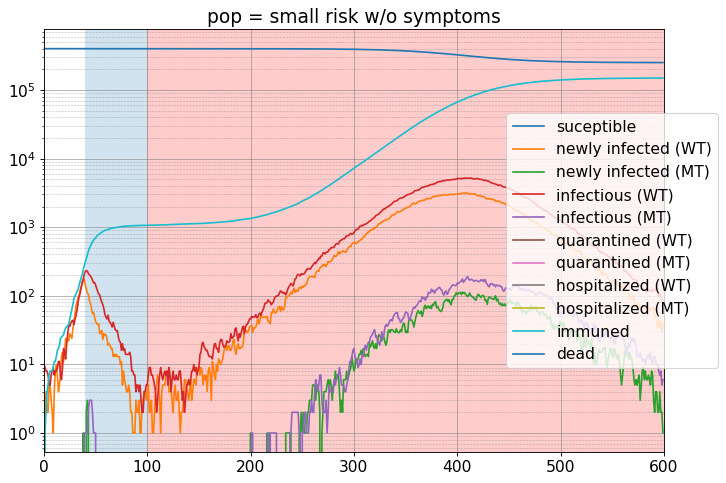

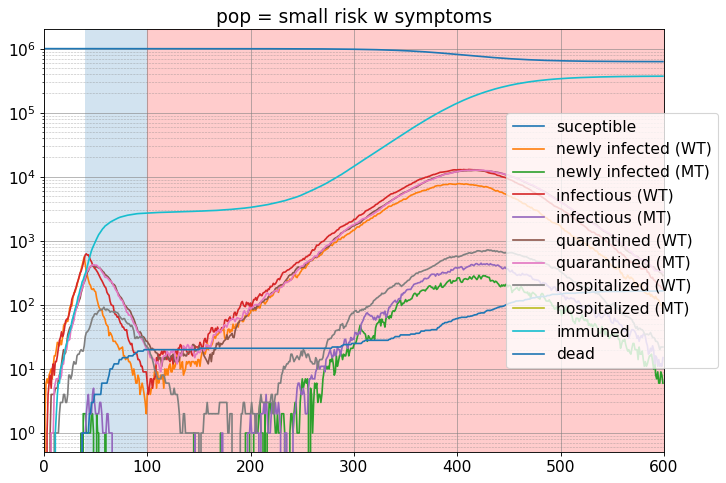

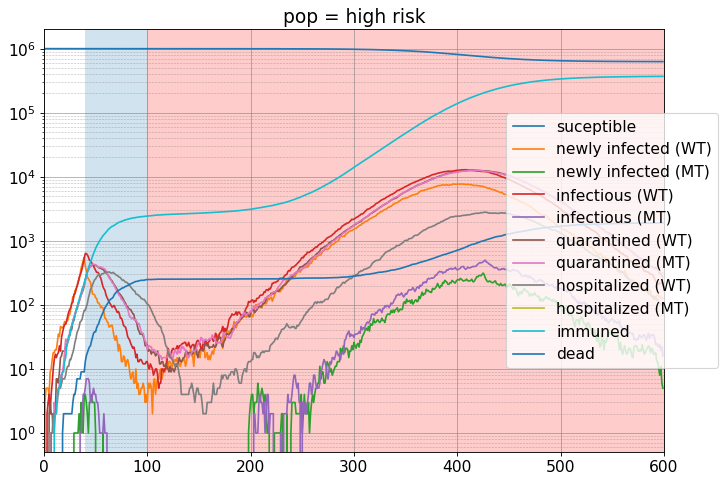

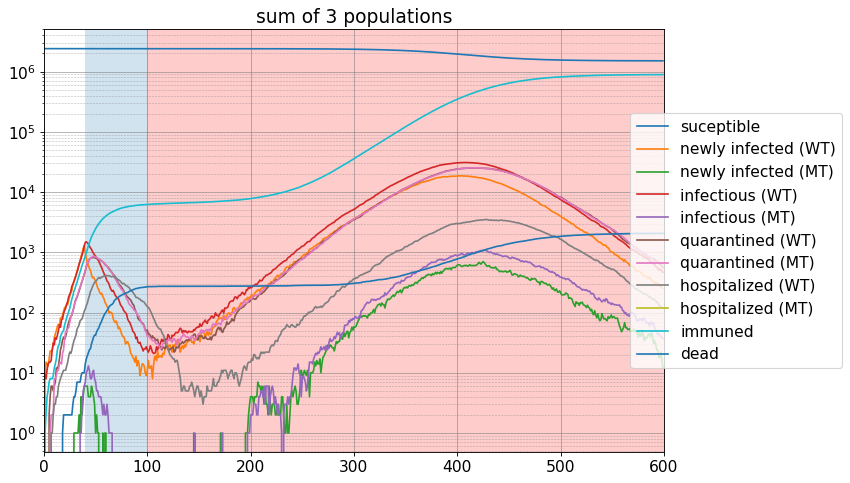

In [0]:
k0 = 0
k1 = T
for j,pop in enumerate(lo_pop) :
  ax = plt.subplot(111)
  ax.semilogy(y[j,:,:].T)
  ax.legend([state_description[s] for s in lo_states], loc=5, bbox_to_anchor=(1.1, 0.5))
  ax.axvspan(phases['distancing'], phases['meds_mildly_distancing'], alpha=0.2)
  ax.axvspan(phases['meds_mildly_distancing'], T, color='r', alpha=0.2)
  ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
  ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
  plt.title('pop = {}'.format(pop['name']))
  plt.xlim(k0,k1)
  #plt.savefig('./drive/My Drive/agent_based_pop{}.png'.format(j))
  plt.show()

ax = plt.subplot(111)
ax.semilogy(y[:,:,:].sum(0).T)
ax.legend([state_description[s] for s in lo_states], loc=5, bbox_to_anchor=(1.3, 0.5))
plt.title('sum of {} populations'.format(len(lo_pop)))
plt.axvspan(phases['distancing'], phases['meds_mildly_distancing'], alpha=0.2)
ax.axvspan(phases['meds_mildly_distancing'], T, color='r', alpha=0.2)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
#plt.savefig('./drive/My Drive/agent_based_all.png')
plt.xlim(k0,k1)
plt.show()

Snapshots of all states (per population)

In [0]:
total_population = y[:,:,0].sum()

curr_counts = y[:, :, 0].sum(0)
for t in np.arange(1, 300) :

  next_counts = update_counts(curr_counts, 1, 0,
                        total_population,
                        lo_pop[j])
  curr_counts = next_counts
  if t % 10 == 0 :
    fig, ax = plt.subplots()
    ax.bar(lo_states, curr_counts)
    ax.set_yscale('log')
    plt.title("pop #{}, iteration #{}".format(j, t))
    plt.show()
  #df = df.append(next_counts)

## SEIR

## def

In [0]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd


def decompose_vec(vec, cuts) :
  """ returns subsets of 'vec' according to 'cuts' 
  Args:
  'vec' : 1D numpy.array
  'cuts' : list of integers or 1D array of integers with sum(cuts) < len(vec)

  Returns:
  'subsets' : list of numpy.array. len(subsets) = len(cuts)
  """

  if len(vec) < sum(cuts) :
    print("too many cuts")
    print(cuts)
    return None
  i = 0
  subsets = []
  for c in cuts :
    subsets += [vec[i:i + c] ]
    i += c

  return subsets

def fun_SEIR_2types(t, y, param):
    """
    Args: 
    t : time variable
    y : vector of state variables
    param : dictionary of parmeters 

    Returns:
    dy : instantenuous change in y at time t
    """
  
    beta1 = np.array(param['beta1'])
    gamma1 = np.array(param['gamma1'])
    gamma1_p = np.array(param['gamma1_p']) # gamma1 prime
    sigma1 = np.array(param['sigma1'])
    delta1 = np.array(param['delta1'])

    beta2 = np.array(param['beta2'])
    gamma2 = np.array(param['gamma2'])
    gamma2_p = np.array(param['gamma2_p']) # gamma2 prime
    sigma2 = np.array(param['sigma2'])
    delta2 = np.array(param['delta2'])

    ndim = beta1.shape[0]

    cuts = [ndim] * int(len(y) / ndim)

    S, S1, S2, E1, E2, E12, E21, I1, I2, I12, I21, R12, D1, D2 = decompose_vec(y, cuts)
    N = y.sum()
    
    # dynamic equations 
    dS = - beta1 * S * (E1.sum() + E12.sum()) / N\
     - beta2 * S * (E2.sum() + E21.sum()) / N  # susceptible to both
    
    dS1 =  - beta1 *  S1 * (E1.sum() + E12.sum()) / N\
     + gamma2 * I2 + gamma2_p * E2# susceptible to t1, immuned to t2
    dS2 =  - beta2 * S2 * (E2.sum() + E21.sum()) / N\
     + gamma1 * I1 + gamma1_p * E1 # susceptible to t2, immuned to t1

    dE1 = beta1 * S * (E1.sum() + E12.sum()) / N\
      - (sigma1 + gamma1_p) * E1 #exposed to t1, immuned to t2
    dE2 = beta2 * S * (E2.sum() + E21.sum()) / N\
     - (sigma2 + gamma2_p) * E2 #exposed to t2, immuned to t2

    dE12 = beta1 * S1 * (E1.sum() + E12.sum()) / N\
     - (sigma1 + gamma1_p) * E12 #exposed to t1, immuned to t2
    dE21 = beta2 * S2 * (E2.sum() + E21.sum()) / N\
     - (sigma2 + gamma2_p) * E21 #exposed to t2, immuned to t1

    dI1 = sigma1 * E1 - (gamma1 + delta1) * I1 #infectious with t1, unimmuned to t2
    dI2 = sigma2 * E2 - (gamma2 + delta2) * I2 #infectious with t2, unimmuned to t1

    dI12 = sigma1 * E12 - (gamma1 + delta1) * I12 #infectious with t1, immuned to t2
    dI21 = sigma2 * E21 - (gamma2 + delta2) * I21 #infectious with t2, immuned to t1

    dR12 = gamma1 * I12 + gamma1_p * E12 + gamma2 * I21 + gamma2_p * E21 # recovered and immuned from t1 and t2

    dD1 = delta1 * (I1 + I12) 
    dD2 = delta2 * (I2 + I21) 

    dy = np.concatenate([dS, dS1, dS2,
                         dE1, dE2, dE12, dE21,
                         dI1, dI2, dI12, dI21,
                         dR12, 
                         dD1, dD2])

    #dy = dy - mu * y  # background mortality

    return dy


In [0]:
#parameters scheduler:

#[a, b] = 'low risk',  'high risk'
param_initial_spread = {
'beta1' : [0.5, 0.5], # S -> E1 (transmission of t1)
'beta2' : [0.5, 0.5], # S -> E2 (transmission of t2)
'sigma1' : [0, 1/5], # E1 -> I1 (asymptomatic -> symptomatic)
'sigma2' : [0, 1/5], # E2 -> I2 (asymptomatic -> symptomatic)
'gamma1_p' : [1/4, 0],  # E1 -> S2 (asymptomatic -> immuned)
'gamma2_p' : [1/4, 0],  # E2 -> S1 (asymptomatic -> immuned)
'gamma1' :  [1/14, 1/14],  # I1 -> S2 (symptomatic1 -> immuned from 1)
'gamma2' : [1/14, 1/14],  # I2 -> S1 (symptomatic2 -> immuned from 2)
'delta1' : [1/200, 1/10],  # I1 -> dead
'delta2' : [1/200, 1/10],  # I2 -> dead
}

param_social_distancing = param_initial_spread.copy()
param_social_distancing['beta1'] = [0.1, 0.1]

param_new_therapy = param_social_distancing.copy()
param_new_therapy['beta1'] = [0.45, 0.45]
param_new_therapy['sigma1'] = [0, 0]

param_new_virus = param_new_therapy.copy()

def get_param(t, intervals) : 
  if t < intervals[0] :
    return param_initial_spread
  if t < intervals[1] :
    return param_social_distancing
  if t < intervals[2] :
    return param_new_therapy
  if t < intervals[3] : 
    return param_new_virus
  return param_social_distancing

## main
Two pathogen variants, 2 populations (low/high risk)

In [0]:

#parameters:

#initial conditions:
S = np.array([800000, 200000])
S1 = np.array([0, 0])
S2 = np.array([0, 0])
E1 = np.array([1, 0])
E2 = np.array([0, 0])
E12 = np.array([0, 0])
E21 = np.array([0, 0])
I1 = np.array([0, 0])
I2 = np.array([0, 0])
I12 = np.array([0, 0])
I21 = np.array([0, 0])
R12 = np.array([0, 0])
D1 = np.array([0, 0])
D2 = np.array([0, 0])

yi = np.concatenate([S, S1, S2,
                     E1, E2, E12, E21,
                     I1, I2, I12, I21,
                     R12,
                     D1, D2])

names = ['S', 'S1', 'S2',
         'E1', 'E2', 'E12', 'E21',
         'I1', 'I2', 'I21', 'I12',
         'R12',
         'D1', 'D2']
ns = 2
var_dic = dict([(nm, 2*i) for i,nm in enumerate(names)])


tmax = 300
intervals = [50, 120, 180, tmax]
t_mutation = 180


tt, dt = np.linspace(0, tmax, tmax + 1, retstep=True)
y_hat = np.zeros((len(tt),len(yi)))
y_hat[0] = yi

# Euler method
for i,t in enumerate(tt[:-1]) :
  if t == t_mutation :
    y_hat[i][var_dic['E2']] = 1
  dy = fun_SEIR_2types(t, y_hat[i], get_param(t, intervals)
                       )
  y_hat[i+1] = y_hat[i] + dy


## results

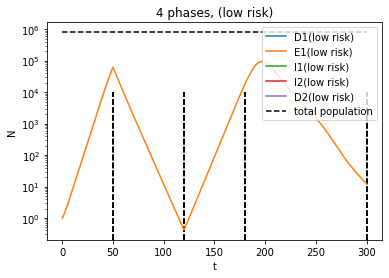

In [0]:
lo_values = ['D1', 'E1', 'I1', 'I2', 'D2']
letters = ['(low risk)', '(high risk)', 'a', 'b', 'c']
legend_var = []
ns = 2
j =  0
for val in lo_values :
  i = var_dic[val]
  plt.semilogy(tt, y_hat[:,i+j])
  legend_var += [val + letters[j]] 

plt.xlabel('t')
plt.semilogy(tt, y_hat[:,::2].sum(1) , '--k')
legend_var += ['total population']
plt.legend(legend_var, loc = 1)
for t in intervals :
  plt.vlines(intervals, 0, yi.sum()/100, linestyles='dashed')


plt.title('4 phases, (low risk)'.format(ns))
plt.ylabel('N')
#plt.savefig('four_phases_low_risk.png', height = 5, width = 10)
plt.show()

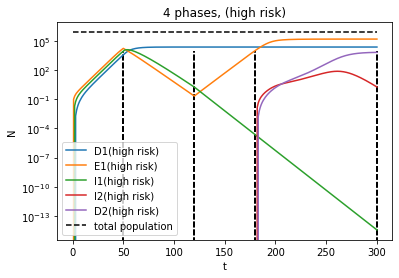

In [0]:
lo_values = ['D1', 'E1', 'I1', 'I2', 'D2']
letters = ['(low risk)', '(high risk)', 'a', 'b', 'c']
legend_var = []
ns = 2
j =  1
for val in lo_values :
  i = var_dic[val]
  plt.semilogy(tt, y_hat[:,i+j])
  legend_var += [val + letters[j]] 

plt.xlabel('t')
plt.semilogy(tt, y_hat[:,::2].sum(1) , '--k')
legend_var += ['total population']
plt.legend(legend_var, loc = 0)
for t in intervals :
  plt.vlines(intervals, 0, yi.sum()/100, linestyles='dashed')


plt.title('4 phases, (high risk)'.format(ns))
plt.ylabel('N')
plt.savefig('four_phases_high_risk.png', height = 5, width = 10)
plt.show()

![alt text](four_phases_low_risk.png)

## Agent-Based Model

#### States:
States: 
- S : susceptible 
- I : newly infected with wilde type
- I' : newly infected with mutant
- Q : quarantined
- Q' : quarantined with mutant
- H : hospitalized
- R : recovered
- D : dead

population properties: (risk, distancing, symptomatic, meds)

In [0]:
import numpy as np
from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
mpl.rcParams.update({'figure.max_open_warning':25})


## Agent-based with multiple populations
3 populations with different properties each has independent dynamic excpet that: infection rate depends on total number of infectious (newly infected) across all 3 populations.

Questions:
1. What states are infectious ? How to calculate viral load?
2. Would symptotimatic individuals be infectious for a longer period?
3. Is the mutant variant infectious ?
4. Meds affect hospitalization or hospitalized mortality rate?
5. hospitalized == severly sick?
6. model parameters: what are the observable?



### header

In [0]:
import numpy as np
from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams.update({'font.size':16})
mpl.rcParams.update({'figure.max_open_warning':25})


### parameters

In [0]:
# baseline parameters
SUCEPTABILITY_FACTOR = 0.4
TIME_NEWLY = 11
TIME_AT_HOSPITAL = 7
TIME_AT_QUARANTINE = 7
HOSPITALIZATION_RATE = 0.1 # out of symptomatic people
HOSPITALIZED_MORTALITY_RATE = 0.1
MUTATION_RATE = 0.0005 # of viral load

# modifier parameters
DISTANCING_FACTOR = 0.2
MILD_DISTANCING_FACTOR = 0.4
MED_FACTOR = 10
RISK_FACTOR = 5



In [0]:
lo_states = ['S',
            'I', 'Ip', 
            'Q', 'Qp',
            'H', 'R', 'D']

state_description = {'S' : 'suceptible', 
                      'I' : 'newly infected (WT)',
                      'Ip' : 'newly infected (mut)',
                      'Q' : 'quarantined (WT)',
                      'Qp' : 'quarantined (mut)',
                      'H' : 'hospitalized',
                      'R' : 'immuned',
                      'D' : 'dead'}

st2i = dict([(nm,i) for i, nm in enumerate(lo_states) ])
i2st = dict([(i, nm) for i, nm in enumerate(lo_states) ])

#transition matrix

no_states = len(lo_states)


def normalize_mat(A) :
    return (A.T / A.sum(1)).T

def get_transitions(properties) :

  A = np.zeros((len(lo_states), len(lo_states)))

  risk = properties['risk']
  distancing = properties['distancing']
  symptomatic = properties['symptomatic']
  meds = properties['meds']


  # susceptibility factor
  distancing = properties['distancing']
  beta = SUCEPTABILITY_FACTOR
  if distancing == 'yes' :
    beta *= DISTANCING_FACTOR
  elif distancing == 'mild' :
    beta *= MILD_DISTANCING_FACTOR

  # disease development factors:
  if symptomatic :
    rho_I = 0  # I -> R
    rho_Ip = 0 # I' -> R
    gamma_I = 1  # I -> Q
    gamma_Ip = 1 # I' -> Q'
  
  else : # no Q state
    rho_I = 1  # ASK: symptomatic people have longer or shorter infectious period ?
    rho_Ip = 1 
    gamma_I = 0 
    gamma_Ip = 0

  rho_Q = 1  # recovery rate Q -> R 
  rho_Qp = rho_Q # Q' -> R
  sigma = rho_Q * HOSPITALIZATION_RATE  # hospitalization rate Q -> H
  sigma_p = rho_Qp * HOSPITALIZATION_RATE 

  rho_H = 1  # hospitalized recovery  H -> R
  delta = 1 * HOSPITALIZED_MORTALITY_RATE # death rate H -> D = %10 of H -> R

  if meds : # ASK: given at Q state or S state?
    sigma = sigma / MED_FACTOR # hispitalization is less likely
    rho_I = rho_I * MED_FACTOR # recovery is more likely / quicker
    #rho_H = rho_H * MED_FACTOR # recovery from hospitalization is more likely

  if risk :
    sigma = sigma * RISK_FACTOR # more hospitalization
    sigma_p = sigma_p * RISK_FACTOR # more hospitalization
    delta = delta * RISK_FACTOR # more deaths
    #gamma_I = gamma_I * RISK_FACTOR # quicker symptoms 
    #gamma_Ip = gamma_Ip * RISK_FACTOR# quicker symptoms 
    
  # populate entries in transition matrix:
    
  A[st2i['S'], st2i['I']] = beta
  A[st2i['S'], st2i['Ip']] = beta # mutant is not infectious ASK!
  A[st2i['I'], st2i['Ip']] = MUTATION_RATE
  A[st2i['I'], st2i['Q']] = gamma_I
  A[st2i['Ip'], st2i['Qp']] = gamma_Ip
  A[st2i['I'], st2i['R']] = rho_I
  A[st2i['Ip'], st2i['R']] = rho_Ip
  A[st2i['Q'], st2i['H']] = sigma
  A[st2i['Qp'], st2i['H']] = sigma_p
  A[st2i['Q'], st2i['R']] = rho_Q
  A[st2i['Qp'], st2i['R']] = rho_Qp
  A[st2i['H'], st2i['R']] = rho_H
  A[st2i['H'], st2i['D']] = delta

  tau = 1
  A = A + np.identity(len(lo_states)) * tau
  
  def set_time_at_state(A, state, time) :
    A[st2i[state],st2i[state]] = 0
    a = A[st2i[state], :].sum()
    b = 1 / time
    A[st2i[state], :] = A[st2i[state], :] / a * b
    A[st2i[state],st2i[state]] = 1 - 1 / time
    return A

  # set time newly
  A = set_time_at_state(A, 'I', TIME_NEWLY)
  A = set_time_at_state(A, 'Ip', TIME_NEWLY)
  # set time at hospital
  A = set_time_at_state(A, 'H', TIME_AT_HOSPITAL)
  # set time at quarantine
  A = set_time_at_state(A, 'Q', TIME_AT_QUARANTINE)
  A = set_time_at_state(A, 'Qp', TIME_AT_QUARANTINE)
  
  return normalize_mat(A)

In [0]:
def sample_from_P(P, times = 1) :
  return np.random.multinomial(times, P)

def update_counts(curr_counts, total_infected_WT, total_infected_mut,
                  total_population,
               properties = {}) :    
  
  A = get_transitions(properties)

  N = total_population
  A[st2i['S'], st2i['I']] *= total_infected_WT / N
  A[st2i['S'], st2i['Ip']] *= total_infected_mut /N

  A = normalize_mat(A)

  new_counts = np.zeros_like(curr_counts)
  for s in lo_states : 
    Ns = curr_counts[st2i[s]]
    P = A[st2i[s]]
    counts_s = sample_from_P(P, Ns)
    new_counts += counts_s

  return new_counts



### population parameters

In [0]:
Ns = 200000
T = 365

pop1 = { 'risk' : False,   
            'distancing' : 'no',
                'meds' : False,
              'symptomatic' : False
              }

pop2 = { 'risk' : False,
               'distancing' : 'no',
                'meds' : False,
              'symptomatic' : True
              }

pop3 = { 'risk' : True,
               'distancing' : 'no',
              'symptomatic' : True,
            'meds' : False
              }

lo_pop = [pop1, pop2, pop3]

y = np.zeros((len(lo_pop), len(lo_states), T))

# initial state:
y[0,st2i['S'],0] = 2*Ns - 1
y[0,st2i['I'],0] = 1

y[1,st2i['S'],0] = 2*Ns
y[1,st2i['I'],0] = 0

y[2,st2i['S'],0] = Ns
y[2,st2i['I'],0] = 0


#phases
phases = {'no_intervention' : 0,
          'distancing' : 30,
          'meds_mildly_distancing' : 90,
          }


### main loop

In [0]:
tt = np.arange(1, T)
for t in tt :
  total_infected_WT = y[:,st2i['I'], t-1].sum()
  total_infected_mut = y[:,st2i['Ip'], t-1].sum()
  total_population = y[:,:,t-1].sum()

  if t == phases['distancing'] :
    for pop in lo_pop :
      pop['distancing'] = 'yes'

  if t == phases['meds_mildly_distancing'] : 
    for pop in lo_pop :
      pop['meds'] = True
      pop['distancing'] = 'mild'
    

  for j, prop in enumerate(lo_pop) :
    curr_counts = y[j, :, t-1]
    next_counts = update_counts(curr_counts,
                  total_infected_WT, total_infected_mut, total_population,
                  properties=prop)
    y[j, :, t] = next_counts


### results:

In [0]:

k = 360
for j,pop in enumerate(lo_pop) :
  ax = plt.subplot(111)
  ax.semilogy(y[j,:,:k].T)
  ax.legend([state_description[s] for s in lo_states], loc=5, bbox_to_anchor=(1.7, 0.5))
  ax.axvspan(phases['distancing'], phases['meds_mildly_distancing'], alpha=0.2)
  ax.axvspan(phases['meds_mildly_distancing'], k, color='r', alpha=0.2)
  plt.title('pop. #{}: risk={}, symp={}'
    .format(j, pop['risk'], pop['symptomatic']))
  
  plt.show()

ax = plt.subplot(111)
ax.semilogy(y[:,:,:k].sum(0).T)
ax.legend([state_description[s] for s in lo_states], loc=5, bbox_to_anchor=(1.7, 0.5))
plt.title('sum of {} populations'.format(len(lo_pop)))
plt.axvspan(phases['distancing'], phases['meds_mildly_distancing'], alpha=0.2)
ax.axvspan(phases['meds_mildly_distancing'], k, color='r', alpha=0.2)
plt.show()

In [0]:
# time at states:
pop = pop1
A = get_trans_mat(risk=pop['risk'], 
                  distancing=pop['distancing'],
                  symptomatic=pop['symptomatic'],
                  meds=pop['meds']
                  )
np.diag(A)

array([0.5       , 0.9       , 0.9       , 0.92857143, 0.92857143,
       0.92857143, 1.        , 1.        ])

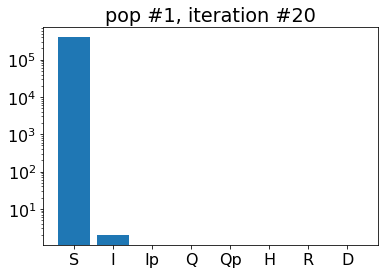

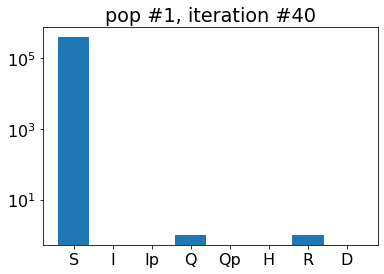

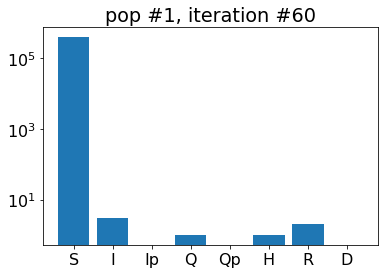

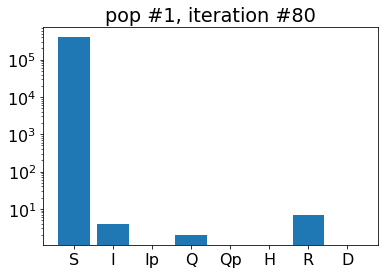

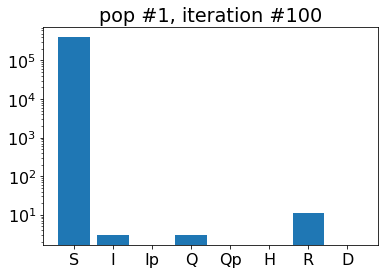

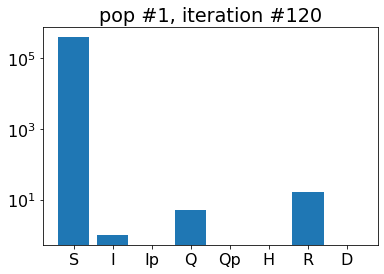

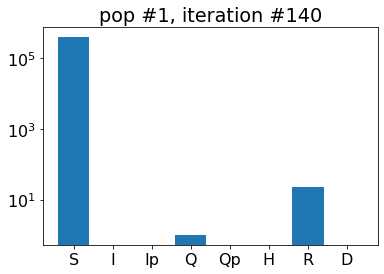

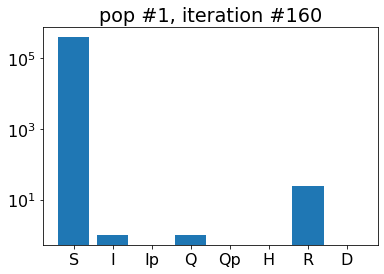

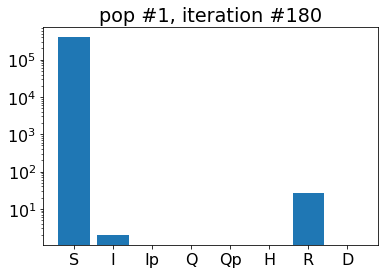

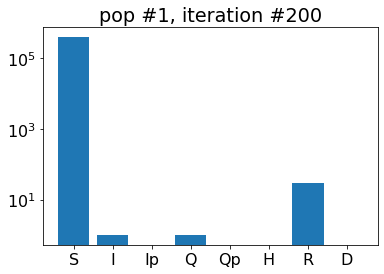

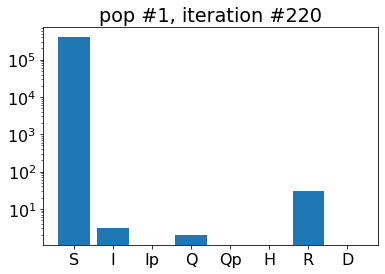

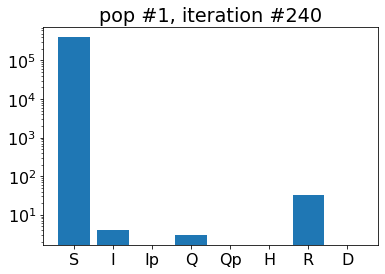

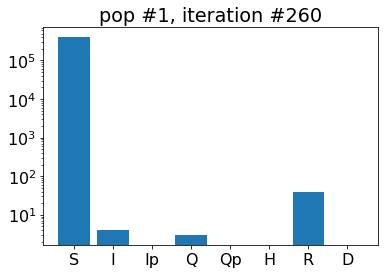

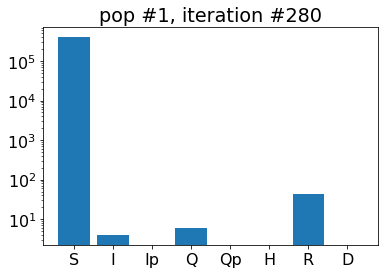

In [0]:
total_population = y[:,:,0].sum()

j = 1
curr_counts = y[j, :, 0]
for t in np.arange(1, 300) :

  next_counts = update_counts(curr_counts, 1, 0,
                        total_population,
                      properties=lo_pop[j])
  curr_counts = next_counts
  if t % 20 == 0 :
    fig, ax = plt.subplots()
    ax.bar(lo_states, curr_counts)
    ax.set_yscale('log')
    plt.title("pop #{}, iteration #{}".format(j, t))
    plt.show()
  #df = df.append(next_counts)

In [0]:
total_population = y[:,:,0].sum()

j = 1
curr_counts = y[j, :, 0]
for t in np.arange(1, 300) :

  next_counts = update_counts(curr_counts, 1, 0,
                        total_population,
                      properties=lo_pop[j])
  curr_counts = next_counts
  if t % 20 == 0 :
    fig, ax = plt.subplots()
    ax.bar(lo_states, curr_counts)
    ax.set_yscale('log')
    plt.title("pop #{}, iteration #{}".format(j, t))
    plt.show()
  #df = df.append(next_counts)

NameError: ignored

In [0]:
T = 300
res = pd.DataFrame()

phases = [30, 60, 90, 110]

for t in range(T) :
  yt = df.current_state.to_list()
  no_E1 = N_in_state(yt, ['E1', 'E12'])
  no_E2 = N_in_state(yt, ['E2', 'E21'])
  no_S = N_in_state(yt, ['S', 'S1', 'S2'])
  no_I1 = N_in_state(yt, ['I1', 'I12'])
  no_I2 = N_in_state(yt, ['I2', 'I21'])
  no_D = N_in_state(yt, ['D'])
  no_R = N_in_state(yt, ['R'])
  
  res = res.append({'t': t, 'E1' : no_E1, 'E2' : no_E2, 'S' : no_S,
                  'I1' : no_I1, 'I2' : no_I2, 'D' : no_D,
                  'R' : no_R, 'N' : N}, ignore_index = True)
  
  if t == phases[0] :
    df.loc[:,'isolating'] = True

  if t == phases[1] :
    df.loc[:,'treatment'] = True
  
  if t == phases[2] :
    df.loc[:,'isolating'] = False

  if t == phases[3] :
    idc = df[df.current_state == 'E1'].index
    df.loc[np.random.choice(idc,3),'current_state'] = 'E2'
  
  df.loc[:,'t'] = t
  def next_state_row(r) :
    return next_state(r['current_state'], param={'trans_mat' : A,
      'N' : N,
       'N_infectious1' : no_E1,
       'N_infectious2' : no_E2,
        'risk' : r['risk'],
      'isolating' : r['isolating'],
      'treatment' : r['treatment']
      })

  df.loc[:,'current_state'] = df.apply(next_state_row, axis=1)
  

AttributeError: ignored

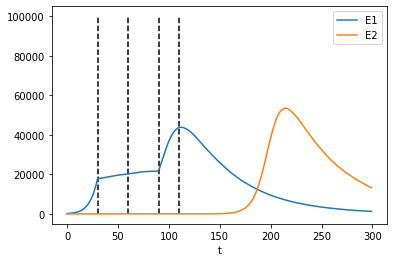

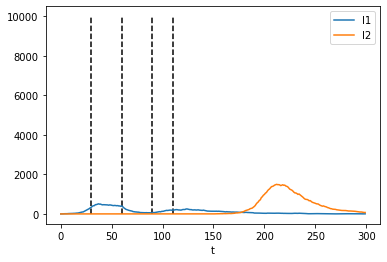

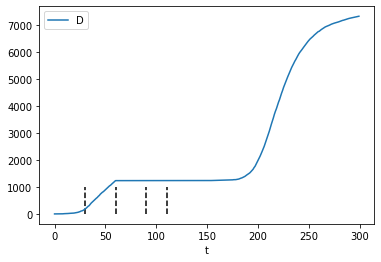

In [0]:
res.plot('t', ['E1', 'E2'])
plt.vlines(phases, ymin=0, ymax = N, linestyles='dashed')
plt.show()

res.plot('t', ['I1', 'I2'])
plt.vlines(phases, ymin=0, ymax = N/10, linestyles='dashed')
plt.show()

res.plot('t', ['D'])
plt.vlines(phases, ymin=0, ymax = N/100, linestyles='dashed')
plt.show()